### 📓 **Data Preprocessing Notebook – Unified Dataset Support**

This notebook handles the initial preparation and validation of datasets used for binary fire classification. It now supports three distinct dataset types through a unified preprocessing pipeline:

- 🔥 **Real-world outdoor dataset (D-Fire)**  
- 🧪 **Synthetic outdoor dataset (MSFFD by Yunnan University)**  
- 🏠 **Real-world indoor dataset (PLOS ONE / Indoor-FS)**  

The notebook performs the following steps:

- Lets you select which dataset type to use (`real`, `synthetic`, or `plos`)  
- Sets the appropriate file paths to images and YOLO-format labels stored in Google Drive  
- Uses the refactored `FireClassificationDataset` class with a `dataset_type` argument  
- Applies torchvision transforms (e.g., resizing and tensor conversion)  
- Instantiates the dataset and verifies image-label logic  
- Optionally previews sample images and binary labels to ensure correctness  

This preprocessing step ensures that the dataset pipeline is correctly configured and that labels are properly interpreted before evaluation or training. Mixed dataset handling remains supported through a separate class and notebook.


### 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is ready to run by:

- Mounting your Google Drive (where your token is stored)  
- Loading your GitHub token from Drive  
- Cloning the project repository into the Colab VM (fresh each time)  
- Navigating into the cloned repo  
- Setting Git credentials to enable committing changes if needed

> ⚠️ **Note**: This cell must be run every time you open this notebook in a new Colab session.


In [1]:
# 🔁 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


Mounted at /content/drive
/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 108 (delta 51), reused 75 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (108/108), 4.09 MiB | 28.88 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/fire-detection-dissertation


### 🗂️ Step 1 – Define Dataset Mode and File Paths

In this step, we define which dataset to preprocess — one of the following three:

- **D-Fire (real-world outdoor dataset)**
- **MSFFD (synthetic outdoor dataset by Yunnan University)**
- **PLOS ONE (real-world indoor dataset)**

We then set the appropriate image and label paths stored in Google Drive.

The selected dataset mode is passed into the unified `FireClassificationDataset` class, which handles all three formats by applying the correct label logic internally:

- `dataset_type = "real"` → D-Fire (class 1 = fire)
- `dataset_type = "synthetic"` → MSFFD (class 0 = fire)
- `dataset_type = "plos"` → PLOS ONE (class 0 = fire)

---

**Requirements**
- Image files must be in `.jpg` format  
- Label files must have matching filenames with `.txt` YOLO-format annotations  
- The dataset type must be set correctly to ensure accurate fire/no-fire label assignment

This step ensures the preprocessing pipeline loads the correct images and labels before training or evaluation.


In [3]:
# 🔧 Choose dataset_mode: 'real', 'synthetic', or 'plos'
dataset_mode = "plos"  # change to 'real' or 'plos' as needed

# 📁 Define image and label directories based on selected dataset
if dataset_mode == "real":
    image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/images"
    label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/labels"

elif dataset_mode == "synthetic":
    image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/images"
    label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/labels"

elif dataset_mode == "plos":
    image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/train/images"
    label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/train/labels"

else:
    raise ValueError("❌ Invalid dataset_mode. Choose either 'real', 'synthetic', or 'plos'.")

print(f"✅ Mode: {dataset_mode}")
print(f"📁 Image directory: {image_dir}")
print(f"📄 Label directory: {label_dir}")


✅ Mode: plos
📁 Image directory: /content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/train/images
📄 Label directory: /content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/train/labels


### 🔧 Step 2 – Import Unified Dataset Class and Define Image Transformations

In this step, we import the unified `FireClassificationDataset` class, which now handles all three dataset types using a `dataset_type` flag:

- `"real"` → for **D-Fire** dataset (fire = class 1)
- `"synthetic"` → for **MSFFD synthetic** dataset (fire = class 0)
- `"plos"` → for **PLOS ONE** indoor real dataset (fire = class 0)

This simplifies the codebase while maintaining correct label logic internally.

We also define image preprocessing using `torchvision.transforms`, which performs:

- 🔁 **Resize**: images to `224×224` for compatibility with ResNet-50  
- 📥 **ToTensor**: converts PIL images to PyTorch tensors  
- 🔢 **Normalization** (optional): if needed for model training/evaluation

These transforms are applied on-the-fly when each image is loaded.


In [4]:
from utils.fire_classification_dataset import FireClassificationDataset
from torchvision import transforms

# Set the dataset_type corresponding to D-Fire, MSFFD, or PLOS ONE
# Must match values used in __init__ of FireClassificationDataset
# Options: "real", "synthetic", "plos"

dataset_type = "plos"  # change to "real" or "plos" as needed

# Define image and label paths (from Step 1)
# image_dir, label_dir should already be defined above

# Select the correct Dataset class with appropriate label logic
DatasetClass = FireClassificationDataset

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required input size for ResNet-50
    transforms.ToTensor()           # Converts PIL Image to PyTorch Tensor in [0, 1]
])


### 📦 Step 3 – Create the Dataset Object and Inspect a Sample

We now instantiate the unified `FireClassificationDataset` class, which supports all three datasets using the `dataset_type` argument:

- `"real"` → D-Fire dataset (outdoor real-world)
- `"synthetic"` → MSFFD dataset (outdoor synthetic)
- `"plos"` → PLOS ONE dataset (indoor real-world)

We pass the following:
- Image and label directory paths defined earlier
- The selected preprocessing transform pipeline
- A string flag (`dataset_type`) to ensure correct label interpretation

This dataset object enables:
- Accessing image–label pairs using indexing (e.g., `dataset[0]`)
- On-the-fly transforms like resizing and tensor conversion
- 🔍 Verifying binary labels are correctly derived based on dataset logic (`0` = no fire, `1` = fire)

We'll preview a sample to confirm:
- ✅ Image shape is `[3, 224, 224]` (RGB channel-first format)
- ✅ Label is a PyTorch integer tensor with value `0` or `1`


In [7]:
# ✅ Create dataset object using the unified FireClassificationDataset class
dataset = FireClassificationDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    transform=transform,
    dataset_type=dataset_mode  # Pass "real", "synthetic", or "plos"
)

# 🔍 Load a sample image-label pair
sample_index = 1000  # You can change this to inspect other samples
image, label = dataset[sample_index]

# ✅ Check image shape and label
print("Image shape:", image.shape)  # Expected: [3, 224, 224]
print("Label:", label.item())       # Expected: 0 (no fire) or 1 (fire)


Image shape: torch.Size([3, 224, 224])
Label: 1


### 🖼️ Step 4 – Visualise a Sample Image and Its Binary Label

Now that the dataset is correctly loading image tensors and binary labels, we visually inspect a sample image to verify:

- The image has been read and transformed correctly
- The shape, orientation, and color channels look normal
- The binary label (`0` = no fire, `1` = fire) matches the image content

This visual confirmation helps validate the preprocessing pipeline before training. We'll use `matplotlib` to display the image and show the label in the title.


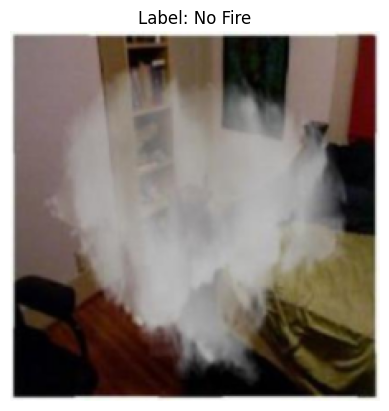

In [13]:
import matplotlib.pyplot as plt

# Select an index to preview
index = 2500  # Adjust this depending on dataset size
image, label = dataset[index]

# Convert image from tensor [C, H, W] to [H, W, C] for plotting
image_np = image.permute(1, 2, 0)

# Display the image and label
plt.imshow(image_np)
plt.title(f"Label: {'Fire' if label.item() == 1 else 'No Fire'}")
plt.axis('off')
plt.show()


In [ ]:
# Copy the updated notebook from Drive to the repo
!cp /content/drive/MyDrive/fire-detection-dissertation/notebooks/02_data_preprocessing.ipynb /content/fire-detection-dissertation/notebooks/


In [ ]:
%cd /content/fire-detection-dissertation
!git add notebooks/02_data_preprocessing.ipynb
!git commit -m "Update 02_data_preprocessing notebook: refactored for synthetic dataset compatibility"
!git push


/content/fire-detection-dissertation
[main 64bf102] Update 02_data_preprocessing notebook: refactored for synthetic dataset compatibility
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/02_data_preprocessing.ipynb (95%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 204.33 KiB | 6.59 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Misharasapu/fire-detection-dissertation.git
   250a453..64bf102  main -> main
